# Number of reactions

Number of reations over energy:
$$
\frac{dN}{dE} = F \cdot t \cdot N_x \cdot \sigma\,,
$$
with the flux $F$, the time $t$, the number of atoms $N$ of the element $x$ and the cross section $\sigma$. 
Moreover, the number of atoms of an element can be calculated as
$$
N_x = \frac{M_D}{\mu_x} \cdot N_A\,,
$$
where $M_D$ is the mass of the detector, $\mu$ the molar mass of element $x$ and $N_A$ the Avogadro constant.

The total number of reations read as
$$
N = \int \text d E\ \frac{dN}{dE}\,.
$$

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import scipy.integrate as integrate

In [2]:
import Cross_section as xsec
import Flux
from super_duper_fiesta.fiesta.fiesta import nuFlux as nF

In [3]:
E = nF.read_flux_file("super_duper_fiesta/data/atm_flux.txt")["E"] # [GeV]
nu_mu = nF.read_flux_file("super_duper_fiesta/data/atm_flux.txt")["nu_mu"]

Element is $H_2O$ and the detector is filled with water, too.

$$
V_D = 1\text{km}^3\,,\
\rho_{H_2O} = 1\text t / \text m^3\,,\
\mu_{H2O} = 0.018 \text{kg} / \text{mol}
$$

In [31]:
# def flux(reaction, E_nu, Nsteps=None, warning=False):
#     '''
#     Here the flux will be calculated using the power_law definition.
#     The output is a list with 
#         1) endindex 
#         2) energy[endindex]
#         3) flux obtained by the power_law as an array
#     '''
#     if reaction == "mu":
#         E_nu_reaction = nF.read_flux_file("super_duper_fiesta/data/atm_flux.txt")["E"]
#         nu_reaction = nF.read_flux_file("super_duper_fiesta/data/atm_flux.txt")["nu_mu"]
#     else:
#         print(f"{reaction} not implemented in the code yet.")
#         return
    
#     popt_list = Flux.power_law_fit(E_nu_reaction, nu_reaction, Nsteps, warning)                
#     F = np.empty((len(E_nu), 2))
#     for i in range(len(popt_list)+1):
#         for j in E_nu:
#             if i == 0 and j <= popt_list[i][1]:
#                 F[list(E_nu).index(j),1] = Flux.power_law(j, popt_list[i][2], popt_list[i][3])
#             elif i == len(popt_list) and j > popt_list[i-1][1]:
#                 F[list(E_nu).index(j),1] = Flux.power_law(j, popt_list[i-1][2], popt_list[i-1][3])
#             elif (i != 0 and i != len(popt_list)) and j <= popt_list[i][1] and j > popt_list[i-1][1]:
#                 F[list(E_nu).index(j),1] = Flux.power_law(j, popt_list[i][2], popt_list[i][3])
#     F[:,0] = E_nu
#     return F # [GeV, flux]

def flux(E_nu, nu, Nsteps=None, warning=False):
    '''
    Here the flux will be calculated using the power_law definition.
    The output is a list with 
        1) endindex 
        2) energy[endindex]
        3) flux obtained by the power_law as an array
    '''
    popt_list = Flux.power_law_fit(E_nu, nu, Nsteps, warning)
    startindex = 0
    F = []
    for i in range(len(popt_list)):
        if i == len(popt_list)-1 and popt_list[i][0] <= len(E_nu): # instead of != use <= and no -1
            endindex = len(E_nu)
            F.append([endindex, E_nu[endindex-1], 
                      Flux.power_law(E_nu[startindex:endindex], popt_list[i][2], popt_list[i][3])]) 
        else:
            endindex = popt_list[i][0]
            F.append([endindex, E_nu[endindex], Flux.power_law(E_nu[startindex:endindex], popt_list[i][2], 
                                                               popt_list[i][3])])
        startindex = endindex
    return F # [endindex, GeV, flux]

def dNmu_dE(element, E_nu, nu, t, Nsteps=None, warning=False):
    '''
    This definition calculates dN/dE, the change of the muonic number by energy.
    The output is the enegry and the corresponding dN/dE.
    '''
    # parameters
    V_D = 1e9 # m^3
    N_A = 6.022*1e23 # mol^-1
    unit_change = 4 * np.pi * 1e-39 # from sr to full solid angle and fb into cm^{-2}
    
    # code
    if element == "oxygen":
        mu_H2O = 0.018 # kg/mol
        rho_H2O = 1e3 # kg/m^3
        rho = rho_H2O
        M_D = V_D * rho
        N_H2O = M_D / mu_H2O * N_A
        N_element = N_H2O
    elif element == "ice":
        mu_H2O = 0.018 # kg/mol
        rho_ice = 920 # kg/m^3
        rho = rho_ice
        M_D = V_D * rho
        N_ice = M_D / mu_H2O * N_A
        N_element = N_ice
    else:
        print(f"Number of element {element} has to be added.")
        return
    
    
    sigma_element = xsec.QMintegration_fit(element, E_nu, Nsteps, warning)[:,1]
    F = flux(E_nu, nu, Nsteps, warning)
    startindex = 0
    dN_dE_values = np.empty((len(E_nu), 2))
    dN_dE_values[:,0] = E_nu
    for i in range(len(F)):
        endindex = F[i][0]
        dN_dE = F[i][2] * t * N_element * sigma_element[startindex:endindex] * unit_change
        dN_dE_values[startindex:endindex,1] = dN_dE
        startindex = endindex
    return dN_dE_values # [GeV, GeV^{-1}]

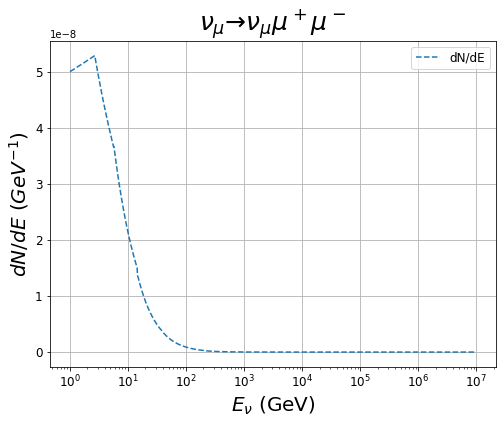

In [5]:
fig, ax = plt.subplots(figsize=(8,6))

D = dNmu_dE("oxygen", E, nu_mu, 1, Nsteps=6)
plt.plot(D[:,0], D[:,1], '--', label = "dN/dE")
plt.legend(fontsize = 12)
plt.title(r'$\nu_\mu \to \nu_\mu \mu^+ \mu^-$', fontsize = 25)
plt.xlabel(r'$E_{\nu}$ (GeV)', fontsize = 20)
plt.ylabel(r'$dN/dE$ ($GeV^{-1}$)', fontsize = 20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.yscale('log')
plt.xscale('log')
# plt.ylim()
# plt.xlim()
plt.grid()

plt.show()

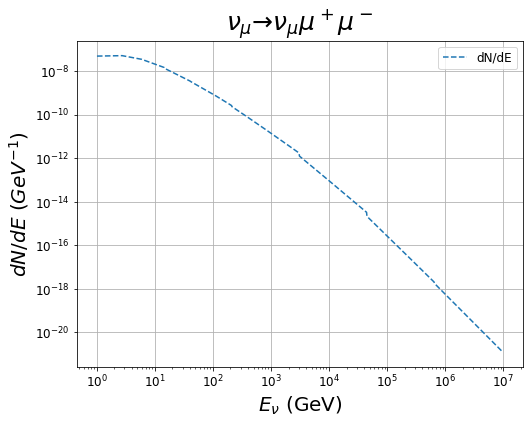

In [6]:
fig, ax = plt.subplots(figsize=(8,6))

D = dNmu_dE("oxygen", E, nu_mu, 1, Nsteps=6)
plt.plot(D[:,0], D[:,1], '--', label = "dN/dE")
plt.legend(fontsize = 12)
plt.title(r'$\nu_\mu \to \nu_\mu \mu^+ \mu^-$', fontsize = 25)
plt.xlabel(r'$E_{\nu}$ (GeV)', fontsize = 20)
plt.ylabel(r'$dN/dE$ ($GeV^{-1}$)', fontsize = 20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.xscale('log')
# plt.ylim()
# plt.xlim()
plt.grid()

plt.show()

Calculating the integral using a lower sum approximation:
$$
U_n(x) = \sum^{n}_{i=1} f(x_i)\cdot\Delta x\,.
$$

In [5]:
def number_mu(element, E_nu, nu, t, a, b, Nsteps=None, warning=False):
    '''
    This definition calculates the number of muonic events by integrating over the energy using the lower sum approximation.
    Output is the integrated dNmu_dE definition.
    '''
    dN_dE = dNmu_dE(element, E_nu, nu, t, Nsteps, warning)
    a_index = list(E_nu).index(a)
    b_index = list(E_nu).index(b)
    delta_x = dN_dE[a_index+1:b_index+1,0] - dN_dE[a_index:b_index,0]
    P = np.multiply(dN_dE[a_index:b_index,1], delta_x)
    U = np.sum(P)
    return U

def N_mu(element, E_nu, nu, t, Nsteps=None, bins=None, warning=False):
    '''
    This definition is just an extension of the number_mu definition.
    The number of steps for the calculation of the flux can be changed. Moreover, the hole energy spectrum can be divided
    into bins. For each of those the number_mu will be calculated.
    The output is 
        1) the index number of the at last used energy
        2) the at last used energy
        3) number of events for the chosen energy range
    '''
    warning_call = False
    if bins == None:
        popt_list = Flux.power_law_fit(E_nu, nu, Nsteps)
        V = [popt_list[k][1] for k in range(len(popt_list))]
        A = np.append(E_nu[0], V)
        B = np.append(V, E_nu[-1])
        endindex_energy = [popt_list[k][0] for k in range(len(popt_list))]
        endindex_energy.append(len(E_nu))
    else:
        N = int(len(E_nu) / bins)
        A = [E_nu[k*N] for k in range(bins)]
        Bb = [E_nu[(k+1)*N] for k in range(bins-1)]
        B = np.append(Bb, E_nu[-1])
        endindex_energy = [(k+1)*N for k in range(bins-1)]
        endindex_energy.append(len(E_nu))
    I_values = np.empty((len(A), 3))
    I_values[:,0] = endindex_energy
    I_values[:,1] = B
    for i in range(len(A)):
        if warning == True and i == len(A)-1:
            warning_call == True
        I = number_mu(element, E_nu, nu, t, A[i], B[i], Nsteps, warning=warning_call)
        I_values[i,2] = I
    return I_values #[index number, GeV, number of events]

def N_plothist(element, E_nu, nu, t, Nsteps=None, bins=None, warning=False):
    '''
    This definition creates a bar diagram using the values obtained from the N_mu definition.
    '''
    N = N_mu(element, E_nu, nu, t, Nsteps, bins, warning)
    N_list = np.empty((len(N), 3))
    startindex = 0
    for i in range(len(N)):
        endindex = int(N[i,0])-1
        N_list[i,0] = (E_nu[startindex] + E_nu[endindex]) / 2
        N_list[i,1] = N[i,2]
        N_list[i,2] = E_nu[endindex] - E_nu[startindex]
        startindex = endindex
    
    fig, ax = plt.subplots(figsize=(10,8))
    plt.bar(N_list[:,0], N_list[:,1], width=N_list[:,2], align='center', linewidth = 2, color='steelblue', 
            edgecolor = 'cyan')
    # This is the location for the annotated text
    # (N_list[i,0] - N_list[i,2]/2, N[i,2]*1.2)
    # Annotating the bar plot with the values
    for k in range(len(N)):
        plt.annotate(round(N[k,2],4), (N_list[k,0] - N_list[k,2]/2, N[k,2]*1.005))
    plt.legend(labels = ['Total number of events'], fontsize = 12)
    plt.title(r'$\nu_\mu \to \nu_\mu \mu^+ \mu^-$', fontsize = 25)
    plt.xlabel(r'$E_{\nu}$ (GeV)', fontsize = 20)
    plt.ylabel(r'$N$ (per bin)', fontsize = 20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.yscale('log')
    plt.xscale('log')
    # plt.ylim()
    # plt.xlim()
    plt.grid()

    plt.show()

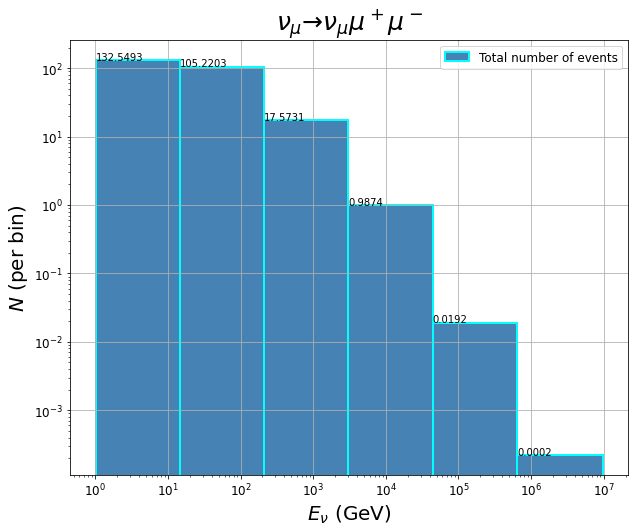

In [8]:
N_plothist("oxygen", E, nu_mu, 10*365*24*3600, Nsteps=6, bins=6)

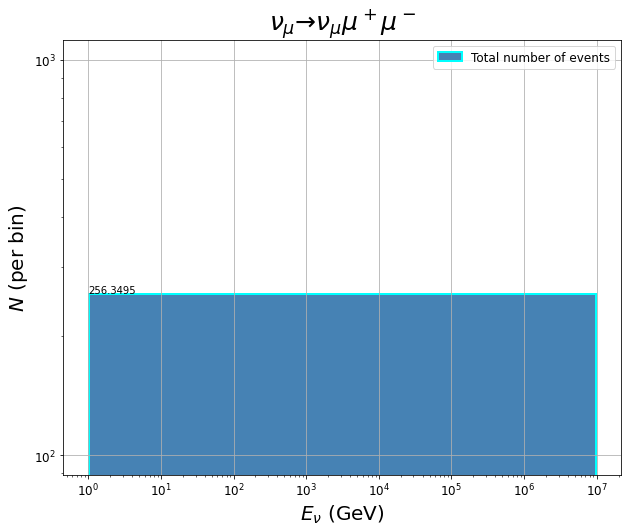

In [9]:
N_plothist("oxygen", E, nu_mu, 10*365*24*3600, Nsteps=6, bins=1)

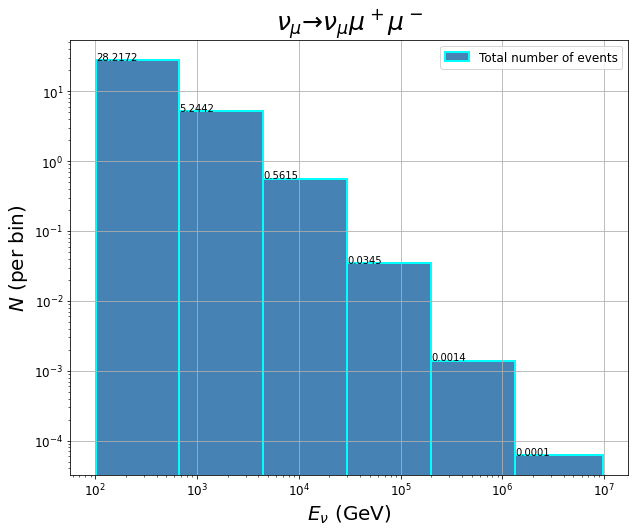

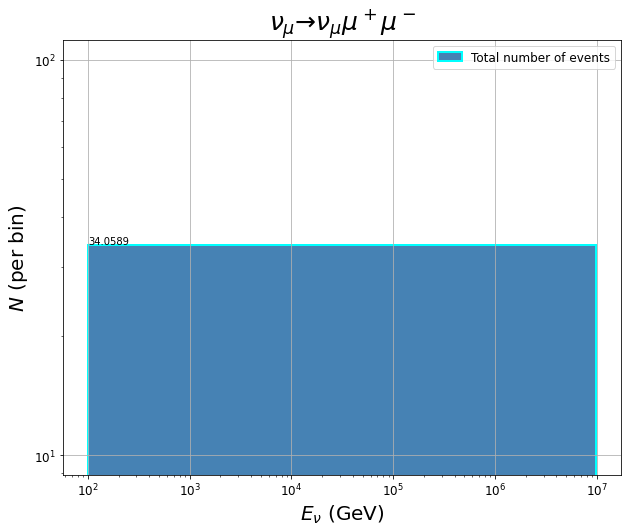

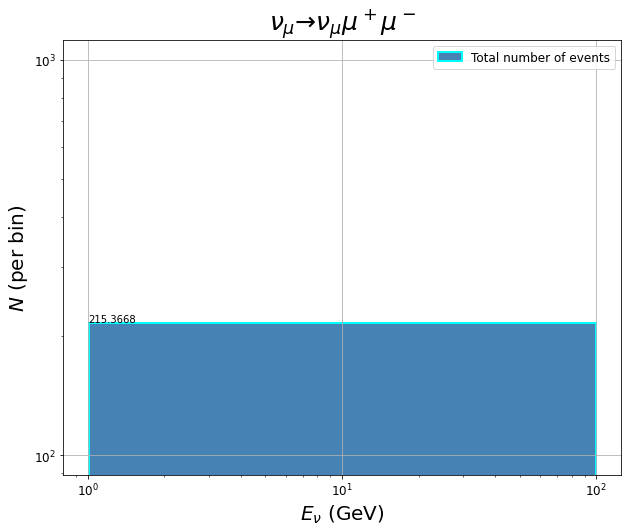

In [10]:
T = []
for i in E:
    if i >= 1e2:
        T.append(i)
M = len(E)-len(T)
N_plothist("oxygen", T, nu_mu[M:], 10*365*24*3600, Nsteps=6, bins=6)
N_plothist("oxygen", T, nu_mu[M:], 10*365*24*3600, Nsteps=6, bins=1)
N_plothist("oxygen", E[:M], nu_mu[:M], 10*365*24*3600, Nsteps=6, bins=1)

## Approximation 

In [11]:
Flux.power_law_fit(E, nu_mu, 6)

[[166, 14.638615375506177, 0.02400750223351278, 2.8784219794851476],
 [332, 212.56903452171053, 0.027539443242674565, 2.961524717621823],
 [498, 3086.73964568386, 0.042009409825268094, 3.0565837835979006],
 [664, 44822.90499966199, 0.3868813151769037, 3.370012573632753],
 [830, 650878.6108404099, 10.06949753392835, 3.7108560068293905],
 [696, 75075.80541199367, 17.60482738895579, 3.7606201533419163]]

In [18]:
V_D = 1e9 # m^3
rho_H2O = 1e3 # kg/m^3
M_D = V_D * rho_H2O
N_A = 6.022*1e23 # mol^-1
unit_change = 4 * np.pi * 1e-39 # from sr to full solid angle and fb into cm^{-2}
mu_H2O = 0.018 # kg/mol
N_H2O = M_D / mu_H2O * N_A

xsec_approx = lambda x: x * np.log(x) #above 10GeV
flux_approx = lambda x: 0.02400750223351278 * x**(-2.8784219794851476) #till E_nu = 10^2GeV

In [19]:
integrate.quad(lambda x: x * np.log(x) * 23.97 * x**(-3.79) * N_H2O * unit_change,
               1, 3086.73964568386)[0]

3.1451132805383795

In [20]:
integrate.quad(lambda x: x * np.log(x) * 23.07 * x**(-3.79) * N_H2O * unit_change,
               212.56903452171053, 3086.73964568386)[0]

0.0021604266794177838

In [15]:
xsec_approx = lambda x: x * np.log(x)
sigma_approx = [x * np.log(x) for x in E]
flux_approx = lambda x: 23.97 * x**(-3.79)
F_approx = [23.97 * x**(-3.79) for x in E]
t = 1

dN_dE = np.multiply(np.multiply(F_approx, sigma_approx), t * N_H2O * unit_change)

In [15]:
def number_mu_approx(E_nu, t, a, b):
    sigma_approx = [x * np.log(x) for x in E_nu]
    F_approx = [23.97 * x**(-3.79) for x in E_nu]
    dN_dE = np.multiply(np.multiply(F_approx, sigma_approx), t * N_H2O * unit_change)
    a_index = list(E_nu).index(a)
    b_index = list(E_nu).index(b)
    delta_x = E_nu[a_index+1:b_index+1] - E_nu[a_index:b_index]
    P = np.multiply(dN_dE[a_index:b_index], delta_x)
    U = np.sum(P)
    return U

def N_mu_approx(E_nu, nu, t, Nsteps=None, bins=None):
    if bins == None:
        popt_list = Flux.power_law_fit(E_nu, nu, Nsteps)
        V = [popt_list[k][1] for k in range(len(popt_list))]
        A = np.append(E_nu[0], V)
        B = np.append(V, E_nu[-1])
        endindex_energy = [popt_list[k][0] for k in range(len(popt_list))]
        endindex_energy.append(len(E_nu))
    else:
        N = int(len(E_nu) / bins)
        A = [E_nu[k*N] for k in range(bins)]
        Bb = [E_nu[(k+1)*N] for k in range(bins-1)]
        B = np.append(Bb, E_nu[-1])
        endindex_energy = [(k+1)*N for k in range(bins-1)]
        endindex_energy.append(len(E_nu))
    I_values = np.empty((len(A), 3))
    I_values[:,0] = endindex_energy
    I_values[:,1] = B
    for i in range(len(A)):
        I = number_mu_approx(E_nu, t, A[i], B[i])
        I_values[i,2] = I
    return I_values #[index number, GeV, number of events]

In [16]:
N_mu_approx(E, nu_mu, 1, bins=6)

array([[1.66000000e+02, 1.46386154e+01, 3.01805385e+39],
       [3.32000000e+02, 2.12569035e+02, 1.50359788e+38],
       [4.98000000e+02, 3.08673965e+03, 2.29257413e+36],
       [6.64000000e+02, 4.48229050e+04, 2.77360445e+34],
       [8.30000000e+02, 6.50878611e+05, 3.02796000e+32],
       [9.99000000e+02, 9.76112782e+06, 3.11997832e+30]])

In [18]:
integrate.quad(lambda x: x * np.log(x) * 23.97 * x**(-3.79) * N_H2O * unit_change,
               1, 14.638615375506177)[0]

2.995481230288884

In [19]:
integrate.quad(lambda x: x * np.log(x) * 23.97 * x**(-3.79) * N_H2O * unit_change,
               14.638615375506177, 212.56903452171053)[0]

0.1473873416450034

In [20]:
integrate.quad(lambda x: x * np.log(x) * 23.97 * x**(-3.79) * N_H2O * unit_change,
               212.56903452171053, 3086.73964568386)[0]

0.0022447086044925994

# IceCube

In [6]:
Ice = np.loadtxt('Pictures\cross_section_mu_IceCube.txt')

In [7]:
E1e2 = []
for i in E:
    if i >= 1e2 and i <= 8e5:
        E1e2.append(i)
nu_mu1e2 = []
for j in range(len(nu_mu)):
    if j >= len(E)-len(E1e2):
        nu_mu1e2.append(nu_mu[j])

In [23]:
len(nu_mu1e2)

557

In [24]:
len(E1e2)

557

[ 1.26534522e-37  3.07963290e-03 -3.24534190e+00  4.65514703e-01
  6.89763020e-36]


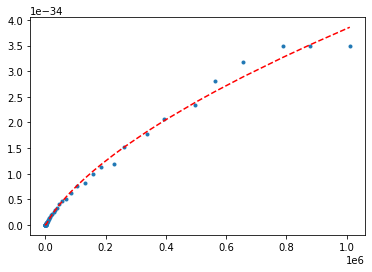

In [25]:
def power_law(E_nu, a, b, c, d, e):
    return a * E_nu**d *  (np.log(E_nu * b) + c) + e

plt.plot(Ice[:,0], Ice[:,1], '.')
popt, pcov = curve_fit(power_law, Ice[:,0], Ice[:,1])
print(popt)
plt.plot(Ice[:,0], power_law(Ice[:,0], *popt), 'r--')
#plt.xscale('log')
#plt.yscale('log')
plt.show()

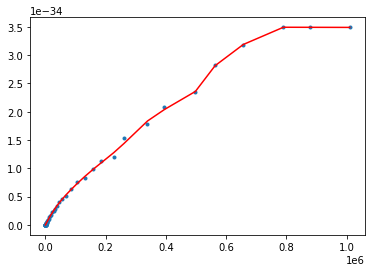

In [26]:
plt.plot(Ice[:,0], Ice[:,1], '.')
poly = np.poly1d(np.polyfit(Ice[:,0], Ice[:,1], 12)) #12
plt.plot(Ice[:,0], poly(Ice[:,0]), color = 'red')
# plt.xscale('log')
# plt.yscale('log')
plt.show()

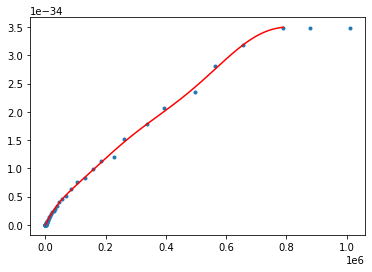

In [27]:
plt.plot(Ice[:,0], Ice[:,1], '.')
poly = np.poly1d(np.polyfit(Ice[:,0], Ice[:,1], 8)) #12
plt.plot(E1e2, poly(E1e2), color = 'red')
# plt.xscale('log')
# plt.yscale('log')
plt.show()

Optimal parameters not found for E > 1010709.9GeV (index: >54).
Fit divided into 3 segments.


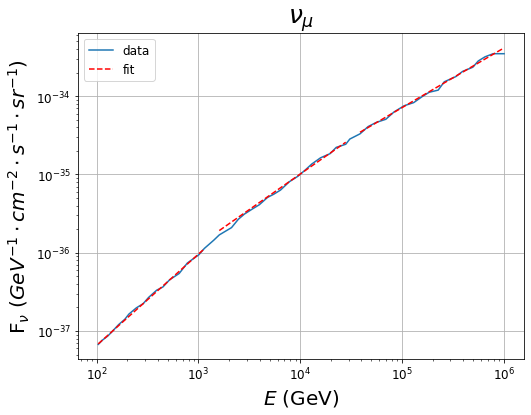

In [8]:
def power_law(E_nu, a, b):
    return np.exp(a + b * np.log(E_nu))

def power_law_fit(E_nu, nu, Nsteps = None):
    '''
    This definition finds for all energies the fit parameters and puts them into a list.
    There a two options:
        - it checks how much the deviation is and if it is to much the fit paramaters will be calculated again
        - if Nsteps has a value then the fit will be divided into Nsteps 
    Output is a list with 
        1) ending index (tells to which energy the deviation was small enough)
        2) corresponding energy to the ending index
        3) parameters for the fitted function
    '''
    start = 0
    popt_list = []
    end = -1
    
    if Nsteps != None:
        N = int(len(E_nu) / Nsteps)
        end = N

    while start <= len(E_nu)-1:
        try:
            popt, pcov = curve_fit(power_law, E_nu[start:end], nu[start:end])
            if Nsteps != None:
                start += N
                end += N
                if start >= len(E_nu):
                    start = len(E_nu)-1
                popt_list.append([start, E_nu[start], *popt])
                
            else:
                for i in range(len(E_nu[start:])):
                    a = power_law(E_nu[start:], *popt)[i] / nu[start:][i] 
                    if a <= 0.99868 or a >= 1.1606:
                        start += i
                        popt_list.append([start, E_nu[start], *popt])
                        break
        except:
            if Nsteps != None and len(popt_list) != Nsteps:
                start_byhand = len(E_nu) - int(len(E_nu)/3.29)
                print(f"Optimal parameters not found for E > {E_nu[start]}GeV (index: >{start}) and, therefore, went back to E = {E_nu[start_byhand]}GeV (index: {start_byhand}).")
                popt, pcov = curve_fit(power_law, E_nu[start_byhand:], nu[start_byhand:])
                popt_list.append([start_byhand, E_nu[start_byhand], *popt])
                break
            else:
                print(f"Optimal parameters not found for E > {E_nu[start]}GeV (index: >{start}).")
                break
    print(f"Fit divided into {len(popt_list)} segments.")
    return popt_list

def plot_power_law_fit_and_data(E_nu, nu, labelfordata, Nsteps = None, E_nu__extrapolation = None):
    '''
    Uses the power_law_fit definition and makes a nice plot with data and fit.
    If E_nu__extrapolation has a value then the missing part will be added using the fit parameters colse to the energy.
    '''
    fig, ax = plt.subplots(figsize=(8,6))
    
    popt_list = power_law_fit(E_nu, nu, Nsteps)
    
    ax.plot(E_nu, nu, label = f"{labelfordata}")

    startindex = 0
    for i in range(len(popt_list)):
        if i == len(popt_list)-1 and popt_list[i][0]-1 != len(E_nu):
            endindex = len(E_nu)
            ax.plot(E_nu[startindex:endindex], power_law(E_nu[startindex:endindex], popt_list[i][2], popt_list[i][3]), 'r--',
                label = "fit")
        else:
            endindex = popt_list[i][0]-1
            ax.plot(E_nu[startindex:endindex], power_law(E_nu[startindex:endindex], popt_list[i][2], popt_list[i][3]), 'r--')
        startindex = endindex+1
    
    if E_nu__extrapolation != None:
        if E_nu__extrapolation >= E_nu[0] and E_nu__extrapolation <=  E_nu[-1]:
            L = np.array([E_nu__extrapolation for i in range(len(E_nu))])
            diff = np.abs(L - E_nu)
            index = np.array([list(diff).index(min(diff)) for i in range(len(popt_list))])
            popt_list_index = np.array([popt_list[i][0] for i in range(len(popt_list))])
            diff_index_array = np.abs(index - popt_list_index)
            diff_index = list(diff_index_array).index(min(diff_index_array))
            
            ax.plot(E_nu__extrapolation, power_law(E_nu__extrapolation, popt_list[diff_index][2], popt_list[diff_index][3]),
                    'o', color = 'green', label = f"{E_nu__extrapolation}GeV")
        else:
            if E_nu__extrapolation < E_nu[0]:
                index = popt_list.index(popt_list[0])
            if E_nu__extrapolation > E_nu[-1]:
                index = popt_list.index(popt_list[-1])
            ax.plot([E_nu__extrapolation, E_nu[index]], power_law([E_nu__extrapolation, E_nu[index]], popt_list[index][2],
                                                                  popt_list[index][3]), 'g--')

    plt.title(r'$\nu_{\mu}$', fontsize = 25)
    plt.ylabel(r'F$_{\nu}$ ($GeV ^{-1} \cdot cm ^{-2}\cdot s ^{-1}\cdot sr ^{-1}$)', fontsize = 20)
    plt.xlabel(r'$E$ (GeV)', fontsize = 20)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.yscale('log')
    plt.xscale('log')
    plt.grid()
    plt.legend(fontsize = 12)   
    plt.show()

plot_power_law_fit_and_data(Ice[:,0], Ice[:,1], 'data', Nsteps = 3)

In [29]:
power_law_fit(Ice[:,0], Ice[:,1], Nsteps = 3)

Optimal parameters not found for E > 1010709.9GeV (index: >54).
Fit divided into 3 segments.


[[18, 1602.1304, -90.97523322600217, 1.164369036209184],
 [36, 38732.83, -88.93696062098583, 0.9075404010619375],
 [54, 1010709.9, -87.38796752338932, 0.7609835911546841]]

In [9]:
def xsec_Ice(E_nu, Nsteps = None):
    P = power_law_fit(Ice[:,0], Ice[:,1], Nsteps)
    xsec_list = []
    for i in range(len(P)+1):
        for j in E_nu:
            if i == 0 and j <= P[i][1]:
                L = power_law(j, P[i][2], P[i][3])
                xsec_list.append(L)
            elif i == len(P) and j >= P[i-1][1]:
                L = power_law(j, P[i-1][2], P[i-1][3])
                xsec_list.append(L)
            elif (i != 0 and i != len(P)) and j <= P[i][1] and j >= P[i-1][1]:
                L = power_law(j, P[i][2], P[i][3])
                xsec_list.append(L)
    return xsec_list

In [28]:
def dNmu_dE_IceCube(element, E_nu, nu, t, Nsteps=None, warning=True):
    '''
    This definition calculates dN/dE, the change of the muonic number by energy.
    The output is the enegry and the corresponding dN/dE.
    '''
    # parameters
    V_D = 1e9 # m^3
    N_A = 6.022*1e23 # mol^-1
    unit_change = 4 * np.pi # from sr to full solid angle and fb into cm^{-2}
    
    # code
    if element == "oxygen":
        mu_H2O = 0.018 # kg/mol
        rho_H2O = 1e3 # kg/m^3
        rho = rho_H2O
        M_D = V_D * rho
        N_H2O = M_D / mu_H2O * N_A
        N_element = N_H2O
    elif element == "ice":
        mu_H2O = 0.018 # kg/mol
        rho_ice = 920 # kg/m^3
        rho = rho_ice
        M_D = V_D * rho
        N_ice = M_D / mu_H2O * N_A
        N_element = N_ice
    else:
        print(f"Number of element {element} has to be added.")
        return
    
    sigma_element = xsec_Ice(E_nu, Nsteps)
    F = flux(E_nu, nu, Nsteps, warning)
    startindex = 0
    dN_dE_values = np.empty((len(E_nu), 2))
    dN_dE_values[:,0] = E_nu
    for i in range(len(F)):
        endindex = F[i][0]
        dN_dE = F[i][2] * t * N_element * sigma_element[startindex:endindex] * unit_change
        dN_dE_values[startindex:endindex,1] = dN_dE
        startindex = endindex
    return dN_dE_values # [GeV, GeV^{-1}]

def number_mu_IceCube(element, E_nu, nu, t, a, b, Nsteps=None, warning=True):
    '''
    This definition calculates the number of muonic events by integrating over the energy using the lower sum approximation.
    Output is the integrated dNmu_dE definition.
    '''
    dN_dE = dNmu_dE_IceCube(element, E_nu, nu, t, Nsteps, warning)
    a_index = list(E_nu).index(a)
    b_index = list(E_nu).index(b)
    delta_x = dN_dE[a_index+1:b_index+1,0] - dN_dE[a_index:b_index,0]
    P = np.multiply(dN_dE[a_index:b_index,1], delta_x)
    U = np.sum(P)
    return U

def N_mu_IceCube(element, E_nu, nu, t, Nsteps=None, bins=None, warning=True):
    '''
    This definition is just an extension of the number_mu definition.
    The number of steps for the calculation of the flux can be changed. Moreover, the hole energy spectrum can be divided
    into bins. For each of those the number_mu will be calculated.
    The output is 
        1) the index number of the at last used energy
        2) the at last used energy
        3) number of events for the chosen energy range
    '''
    warning_call = False
    if bins == None:
        popt_list = Flux.power_law_fit(E_nu, nu, Nsteps)
        V = [popt_list[k][1] for k in range(len(popt_list))]
        A = np.append(E_nu[0], V)
        B = np.append(V, E_nu[-1])
        endindex_energy = [popt_list[k][0] for k in range(len(popt_list))]
        endindex_energy.append(len(E_nu))
    else:
        N = int(len(E_nu) / bins)
        A = [E_nu[k*N] for k in range(bins)]
        Bb = [E_nu[(k+1)*N] for k in range(bins-1)]
        B = np.append(Bb, E_nu[-1])
        endindex_energy = [(k+1)*N for k in range(bins-1)]
        endindex_energy.append(len(E_nu))
    I_values = np.empty((len(A), 3))
    I_values[:,0] = endindex_energy
    I_values[:,1] = B
    for i in range(len(A)):
        if warning == True and i == len(A)-1:
            warning_call == True
        I = number_mu_IceCube(element, E_nu, nu, t, A[i], B[i], Nsteps, warning=warning_call)
        I_values[i,2] = I
    return I_values #[index number, GeV, number of events]

def N_plothist_IceCube(element, E_nu, nu, t, Nsteps=None, bins=None, warning=True):
    '''
    This definition creates a bar diagram using the values obtained from the N_mu definition.
    '''
    N = N_mu_IceCube(element, E_nu, nu, t, Nsteps, bins, warning)
    N_list = np.empty((len(N), 3))
    startindex = 0
    for i in range(len(N)):
        endindex = int(N[i,0])-1
        N_list[i,0] = (E_nu[startindex] + E_nu[endindex]) / 2
        N_list[i,1] = N[i,2]
        N_list[i,2] = E_nu[endindex] - E_nu[startindex]
        startindex = endindex
    
    fig, ax = plt.subplots(figsize=(10,8))
    plt.bar(N_list[:,0], N_list[:,1], width=N_list[:,2], align='center', linewidth = 2, color='steelblue', 
            edgecolor = 'cyan')
    # This is the location for the annotated text
    # (N_list[i,0] - N_list[i,2]/2, N[i,2]*1.2)
    # Annotating the bar plot with the values
    for k in range(len(N)):
        plt.annotate(round(N[k,2],2), (N_list[k,0] - N_list[k,2]/2, N[k,2]*1.005))
    plt.legend(labels = ['Total number of events'], fontsize = 12)
    plt.title(r'$\nu_\mu \to \nu_\mu \mu^+ \mu^-$', fontsize = 25)
    plt.xlabel(r'$E_{\nu}$ (GeV)', fontsize = 20)
    plt.ylabel(r'$N$', fontsize = 20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
#     plt.yscale('log')
    plt.xscale('log')
    # plt.ylim()
    # plt.xlim()
    plt.grid()

    plt.show()

Optimal parameters not found for E > 1010709.9GeV (index: >54).
Fit divided into 3 segments.
Optimal parameters not found for E > 1010709.9GeV (index: >54).
Fit divided into 3 segments.
Optimal parameters not found for E > 1010709.9GeV (index: >54).
Fit divided into 3 segments.
Optimal parameters not found for E > 1010709.9GeV (index: >54).
Fit divided into 3 segments.
Optimal parameters not found for E > 1010709.9GeV (index: >54).
Fit divided into 3 segments.
Optimal parameters not found for E > 1010709.9GeV (index: >54).
Fit divided into 3 segments.


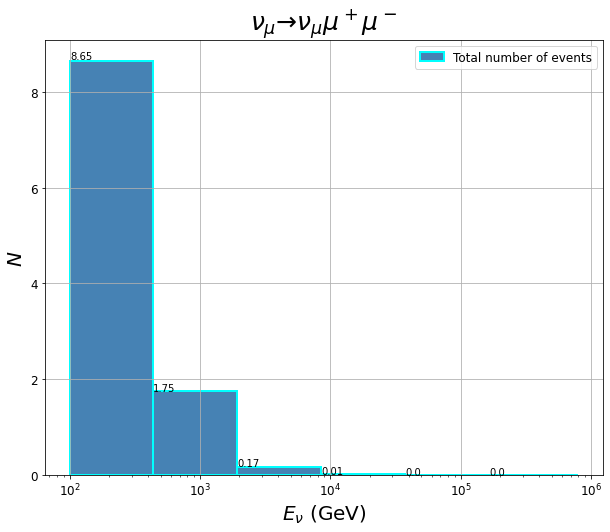

In [32]:
N_plothist_IceCube("oxygen", E1e2, nu_mu1e2, 10*365*24*3600, Nsteps = 3, bins = 6)

Optimal parameters not found for E > 1010709.9GeV (index: >54).
Fit divided into 3 segments.


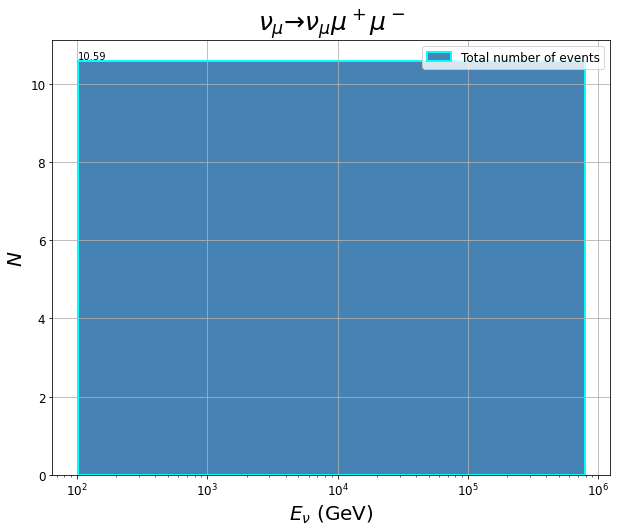

In [33]:
N_plothist_IceCube("oxygen", E1e2, nu_mu1e2, 10*365*24*3600, Nsteps = 3, bins = 1)

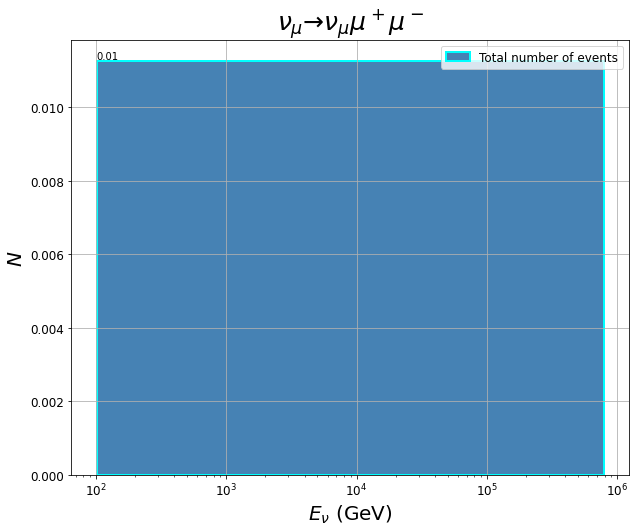

In [74]:
N_plothist("oxygen", E1e2, nu_mu1e2, 10*365*24*3600, Nsteps = 6, bins = 1)

Optimal parameters not found for E > 1010709.9GeV (index: >54).
Fit divided into 3 segments.


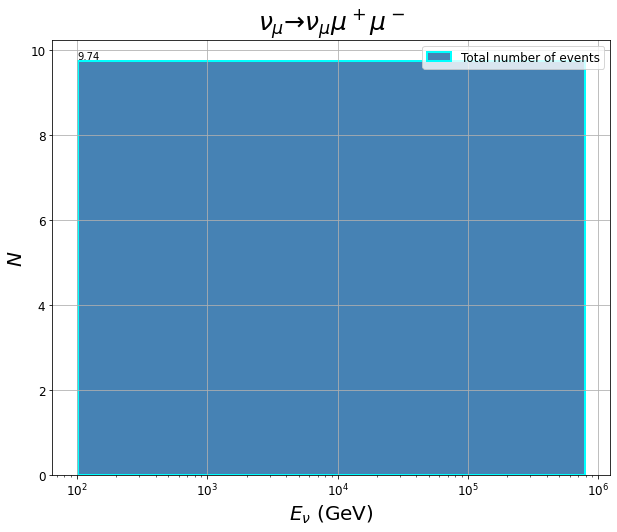

In [30]:
N_plothist_IceCube("ice", E1e2, nu_mu1e2, 10*365*24*3600, Nsteps = 3, bins = 1)